In [139]:
%matplotlib inline

import numpy as np
import pandas as pd
#
import matplotlib.pyplot as plt

import matplotlib.ticker as ticker
# from collections import namedtuple

try:
    # for Python2
    from Tkinter import *   ## notice capitalized T in Tkinter 
except ImportError:
    # for Python3
    from tkinter import *   ## notice lowercase 't' in tkinter here


In [140]:
def _parse_line(line):
    """
    Do a regex search against all defined regexes and
    return the key and match result of the first matching regex

    """

    for key, rx in rx_dict.items():
        match = rx.search(line)
        if match:
            return key, match
    # if there are no matches
    return None, None

In [141]:
methods=['scalar', 'avx2', 'avx512_512', 'avx512_256']

rx_dict = {
    'build': re.compile(r'(Generation|Cuckoo Table Generation:) (?P<build>.*) ms \n'),
    'probe': re.compile(r'Join core: (?P<probe>\d*) ms \n'),
}

data = []
build = None
probe = None
        
for m in methods:
    for i in range(10, 100, 10):
        with open('/home/flav/Mestrado/MHaJoL/data/out/joins/_'+str(i)+'/'+m+'.out', 'r') as file_object:
            line = file_object.readline()
            while line:
                # at each line check for a match with a regex
                key, match = _parse_line(line)
                
                # extract build time
                if key == 'build':
                    build = match.group('build')
                    build = int(build)

                # extract probe time
                if key == 'probe':
                    probe = match.group('probe')
                    probe = int(probe)

                if (build is not None and probe is not None):
                    # create a dictionary containing this row of data
                    row = {
                        'buildTime': build,
                        'probeTime': probe,
                        'method': m,
                        'selectivity': i
                    }
                    # append the dictionary to the data list
                    data.append(row)
                line = file_object.readline()

            # create a pandas DataFrame from the list of dicts
            df = pd.DataFrame(data)
            # set the School, Grade, and Student number as the index
#             df.set_index(['buildTime', 'probeTime', 'method', 'selectivity'], inplace=True)
#             # consolidate df to remove nans
#             df = df.groupby(level=df.index.names).first()
#             # upgrade Score from float to integer
#             df = df.apply(pd.to_numeric, errors='ignore')
df.head(100)


,buildTime,method,probeTime,selectivity
0,196,scalar,20,10
1,196,scalar,20,10
2,196,scalar,20,10
3,196,scalar,20,10
4,196,scalar,20,10
5,196,scalar,20,10
6,196,scalar,20,10
7,196,scalar,20,10
8,196,scalar,20,10
9,196,scalar,20,10


In [142]:
dfQuantile1 = df.groupby(['method', 'selectivity']).quantile(q=0.25, axis=0, numeric_only=True, interpolation='linear').reset_index()
dfQuantile1 = dfQuantile1.rename(index=str, columns={"buildTime": "first"})
dfQuantile1 = dfQuantile1.drop(columns=['probeTime'])

dfQuantile2 = df.groupby(['method', 'selectivity']).quantile(q=0.75, axis=0, numeric_only=True, interpolation='linear').reset_index()
dfQuantile2 = dfQuantile2.rename(index=str, columns={"buildTime": "third"}).drop(columns=['probeTime'])

dfQuantile = pd.merge(dfQuantile1, dfQuantile2, how='inner', on=['method', 'selectivity'])
dfQuantile['IQR'] = dfQuantile['third'] - dfQuantile['first']

dfAggMedian = df.groupby(['method', 'selectivity'], as_index = False).aggregate(np.median)
dfAggMedian = dfAggMedian.rename(index=str, columns={"buildTime": "median"}).drop(columns=['probeTime'])
dfIQR = pd.merge(dfQuantile, dfAggMedian, how='inner', on=['method', 'selectivity'])
dfIQR = pd.merge(dfIQR, df, how='inner', on=['method', 'selectivity']).drop(columns=['probeTime'])

dfIQR['calc1'] = dfIQR['first'] - (1.5 * dfIQR['IQR'])
dfIQR['calc2'] = dfIQR['third'] - (1.5 * dfIQR['IQR'])

dfIQR['values'] = np.where((dfIQR['buildTime'] < (dfIQR['first'] - (0.5 * dfIQR['IQR']))) | (dfIQR['buildTime'] < (dfIQR['third'] - (0.5 * dfIQR['IQR']))), dfIQR['buildTime'], dfIQR['median'])

dfIQR = dfIQR.drop(columns=['buildTime', 'first', 'third', 'IQR', 'median', 'calc1', 'calc2'])
dfIQR = dfIQR.rename(index=str, columns={"values": "value"})

dfAggAVG = dfIQR.groupby(['method', 'selectivity'], as_index = False).aggregate(['mean','std'])


dfAggAVG.head(100)

value          
                              mean       std
method     selectivity                      
avx2       10            16.554455  0.497272
           20            16.000000  0.000000
           30            16.000000  0.000000
           40            15.772277  0.419571
           50            15.696040  0.460194
           60            15.000000  0.000000
           70            15.534653  0.499045
           80            15.591089  0.491876
           90            15.000000  0.000000
avx512_256 10            16.745875  0.443128
           20            16.000000  0.000000
           30            16.551155  0.497650
           40            16.636964  0.481140
           50            16.000000  0.000000
           60            16.000000  0.000000
           70            16.514851  0.500055
           80            16.000000  0.000000
           90            16.000000  0.000000
avx512_512 10            16.805281  0.404456
           20            16.000000  0.000000
           30            16.000000  0.000000
           40            16.000000  0.000000
           50            15.666667  0.471664
           60            15.742574  0.437457
           70            15.749175  0.433727
           80            15.712871  0.452671
           90            15.000000  0.000000
scalar     10           190.575586  0.551470
           20           188.712871  0.473969
           30           187.619519  0.573847
           40           186.442716  0.681813
           50           185.445545  0.814460
           60           183.574257  0.602955
           70           181.448373  0.724523
           80           178.247525  0.938055
           90           171.960396  1.250557

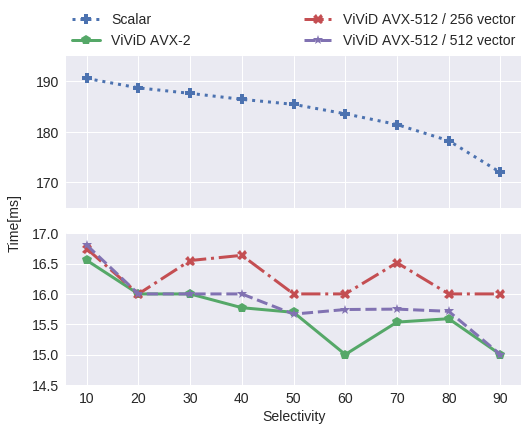

In [143]:
#X axis
n_groups = 9
index = np.arange(n_groups)
left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height

# NP arrays of values
dfMethodVec = dfAggAVG.xs("avx2", level='method')['value'].reset_index().sort_values('selectivity')
dfValuesVec = dfMethodVec["mean"]

dfMethod = dfAggAVG.xs("scalar", level='method')['value'].reset_index().sort_values('selectivity')
dfValues = dfMethod["mean"]

dfMethodVi = dfAggAVG.xs("avx512_512", level='method')['value'].reset_index().sort_values('selectivity')
dfValuesVi = dfMethodVi["mean"]

dfMethodVi2 = dfAggAVG.xs("avx512_256", level='method')['value'].reset_index().sort_values('selectivity')
dfValuesVi2 = dfMethodVi2["mean"]

#Style configs
plt.style.use('seaborn')
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)

fig, (ax, ax2) = plt.subplots(2, 1, sharex=True)

# fig, ax = plt.subplots()
# ax.grid(alpha=0.4)
# ax2.grid(alpha=0.4)

fig.tight_layout()
fig.subplots_adjust(left=0.19, bottom=0.09, right=0.98, top=0.92, wspace=0.17, hspace=0.17)

#Plot
ax.plot(index, dfValues, linestyle=':', marker='P', label='Scalar', linewidth=3,markersize=10)
ax.plot(index, dfValuesVec,  linestyle='-', marker='p', label='ViViD AVX-2', linewidth=3,markersize=10)
ax.plot(index, dfValuesVi2,  linestyle='-.', marker='X', label='ViViD AVX-512 / 256 vector', linewidth=3,markersize=10)
ax.plot(index, dfValuesVi,  linestyle='--', marker='*', label='ViViD AVX-512 / 512 vector', linewidth=3,markersize=10)

ax2.plot(index, dfValues,  linestyle=':', marker='P', label='Scalar', linewidth=3,markersize=10)
ax2.plot(index, dfValuesVec,  linestyle='-', marker='p', label='ViViD AVX-2', linewidth=3,markersize=10)
ax2.plot(index, dfValuesVi2,  linestyle='-.', marker='X', label='ViViD AVX-512 / 256 vector', linewidth=3,markersize=10)
ax2.plot(index, dfValuesVi,  linestyle='--', marker='*', label='ViViD AVX-512 / 512 vector', linewidth=3,markersize=10)

#Axis and labels
ax2.set_xlabel('Selectivity', fontsize=14)
ax.set_xticklabels(('0', '10', '20', '30', '40', '50', '60', '70', '80', '90'))
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.,fancybox=True, fontsize=14)
fig.text(0.1, 0.5, 'Time[ms]', ha='center', va='center', rotation='vertical', fontsize=14)

#Break the y axis
ax.set_ylim(165, 195)  # outliers only
ax2.set_ylim(14.5, 17)  # most of the data

# ax.spines['bottom'].set_visible(False)
# ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

# d = .015  # how big to make the diagonal lines in axes coordinates
# # arguments to pass to plot, just so we don't keep repeating them
# kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
# ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
# ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

# kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
# ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
# ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal


plt.rcParams.update({'font.size': 14})

#Draw and save
plt.show()
fig.savefig('/home/flav/Mestrado/MHaJoL/data/out/plots/time.png', facecolor='white', edgecolor='none', bbox_inches='tight')
fig.clf()


In [144]:
#milion tuples per second

dfIQR['seconds']=dfIQR['value']/1000
dfIQR['tuplesPerSecond']=1500000/dfIQR['seconds']
dfIQR['Mtps']=1.5/dfIQR['seconds']

dfIQR=dfIQR.drop(columns=['seconds', 'tuplesPerSecond', 'value']).rename(index=str, columns={"Mtps": "value"})

dfAggAVGM = dfIQR.groupby(['method', 'selectivity'], as_index = False).aggregate(['mean','std'])

dfAggAVGM.head(100)

value          
                              mean       std
method     selectivity                      
avx2       10            90.692341  2.742309
           20            93.750000  0.000000
           30            93.750000  0.000000
           40            95.173267  2.622316
           50            95.649752  2.876210
           60           100.000000  0.000000
           70            96.658416  3.119030
           80            96.305693  3.074227
           90           100.000000  0.000000
avx512_256 10            89.639148  2.453636
           20            93.750000  0.000000
           30            90.710542  2.744394
           40            90.237333  2.653345
           50            93.750000  0.000000
           60            93.750000  0.000000
           70            90.910745  2.757654
           80            93.750000  0.000000
           90            93.750000  0.000000
avx512_512 10            89.311541  2.241669
           20            93.750000  0.000000
           30            93.750000  0.000000
           40            93.750000  0.000000
           50            95.833333  2.947900
           60            95.358911  2.734104
           70            95.317657  2.710792
           80            95.544554  2.829195
           90           100.000000  0.000000
scalar     10             7.870959  0.022832
           20             7.948634  0.020025
           30             7.994979  0.024545
           40             8.045474  0.029511
           50             8.088785  0.035714
           60             8.171169  0.026936
           70             8.266947  0.033174
           80             8.415498  0.044441
           90             8.723401  0.063674

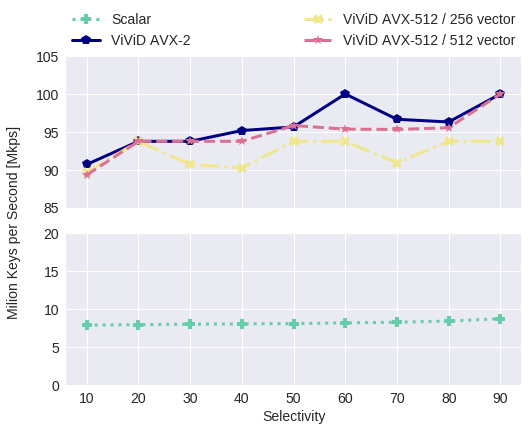

In [145]:
#X axis
n_groups = 9
index = np.arange(n_groups)

# NP arrays of values
dfMethodVec = dfAggAVGM.xs("avx2", level='method')['value'].reset_index().sort_values('selectivity')
dfValuesVec = dfMethodVec["mean"]

dfMethod = dfAggAVGM.xs("scalar", level='method')['value'].reset_index().sort_values('selectivity')
dfValues = dfMethod["mean"]

dfMethodVi = dfAggAVGM.xs("avx512_512", level='method')['value'].reset_index().sort_values('selectivity')
dfValuesVi = dfMethodVi["mean"]

dfMethodVi2 = dfAggAVGM.xs("avx512_256", level='method')['value'].reset_index().sort_values('selectivity')
dfValuesVi2 = dfMethodVi2["mean"]

fig, (ax, ax2) = plt.subplots(2, 1, sharex=True)

plt.style.use('seaborn')
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)

# fig, ax = plt.subplots()
# ax.grid(alpha=0.4)
# ax2.grid(alpha=0.4)

fig.tight_layout()
fig.subplots_adjust(left=0.19, bottom=0.09, right=0.98, top=0.92, wspace=0.17, hspace=0.17)

#Plot
ax.plot(index, dfValues, color='mediumaquamarine', linestyle=':', marker='P', label='Scalar', linewidth=3,markersize=10)
ax.plot(index, dfValuesVec, color='navy', linestyle='-', marker='p', label='ViViD AVX-2', linewidth=3,markersize=10)
ax.plot(index, dfValuesVi2, color='khaki', linestyle='-.', marker='X', label='ViViD AVX-512 / 256 vector', linewidth=3,markersize=10)
ax.plot(index, dfValuesVi, color='palevioletred', linestyle='--', marker='*', label='ViViD AVX-512 / 512 vector', linewidth=3,markersize=10)

ax2.plot(index, dfValues, color='mediumaquamarine', linestyle=':', marker='P', label='Scalar', linewidth=3,markersize=10)
ax2.plot(index, dfValuesVec, color='navy', linestyle='-', marker='p', label='ViViD AVX-2', linewidth=3,markersize=10)
ax2.plot(index, dfValuesVi2, color='khaki', linestyle='-.', marker='X', label='ViViD AVX-512 / 256 vector', linewidth=3,markersize=10)
ax2.plot(index, dfValuesVi, color='palevioletred', linestyle='--', marker='*', label='ViViD AVX-512 / 512 vector', linewidth=3,markersize=10)

#Axis and labels
ax2.set_xlabel('Selectivity', fontsize=14)
ax.set_xticklabels(('0', '10', '20', '30', '40', '50', '60', '70', '80', '90'))
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.,fancybox=True, fontsize=14)
fig.text(0.1, 0.5, 'Milion Keys per Second [Mkps]', ha='center', va='center', rotation='vertical', fontsize=14)

#Break the y axis
ax.set_ylim(85, 105)  # outliers only
ax2.set_ylim(0, 20)  # most of the data

# ax.spines['bottom'].set_visible(False)
# ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

# d = .015  # how big to make the diagonal lines in axes coordinates
# # arguments to pass to plot, just so we don't keep repeating them
# kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
# ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
# ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

# kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
# ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
# ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal


plt.rcParams.update({'font.size': 14})

#Draw and save
plt.show()
fig.savefig('/home/flav/Mestrado/MHaJoL/data/out/plots/mtps.png', facecolor='white', edgecolor='none',  bbox_inches='tight')
fig.clf()